# Distributed Synchronization for Ad-Hoc Acoustic Sensor Networks
### (N. Knäpper, A. Chinaev \& G. Enzner)

### A demo to the IWAENC 2022 publication "Distributed Synchronization for Ad-Hoc Acoustic Sensor Networks Using Closed-Loop Double-Cross-Correlation Processing (DXCP)" written by A. Chinaev and G. Enzner.

### For presentation at the Satellite Workshop of DFG research unit Acoustic Sensor Networks (ASN) \& european training network Service-Oriented, Ubiquitous, Network-Driven Sound (SOUNDS).

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

from paderbox.io import load_audio
from lazy_dataset.database import JsonDatabase

import sys
sys.path.append('modules/')
from demo_utils import *
from audio_reader import AudioReader # customized, previously part of asn_testbed

## 1. Demo configuration

In [2]:
DATA_ROOT = f'{os.getcwd()}/data/'
SIMULATE_ONLINE = True #True: Online sequential; False: Offline simulation on several processor cores
CONTROL_INIT_SRO_EST = False #False: Regular SRO Estimation as seen in [1], True: Control initial SRO Estimation (experimental)

sig_len_sec = 150
ssnr_t_max = sig_len_sec

fs_Hz = 16e3
frame_len = 2**11
testbed_json = DATA_ROOT+'json/testbed.json'
json_pos = DATA_ROOT+'json/positions.json'
room_model = DATA_ROOT+'room_model.stl'
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
example_db = JsonDatabase(testbed_json)
examples = example_db.get_dataset('examples')
ex_id = 0

### Set, verify and plot the network topology

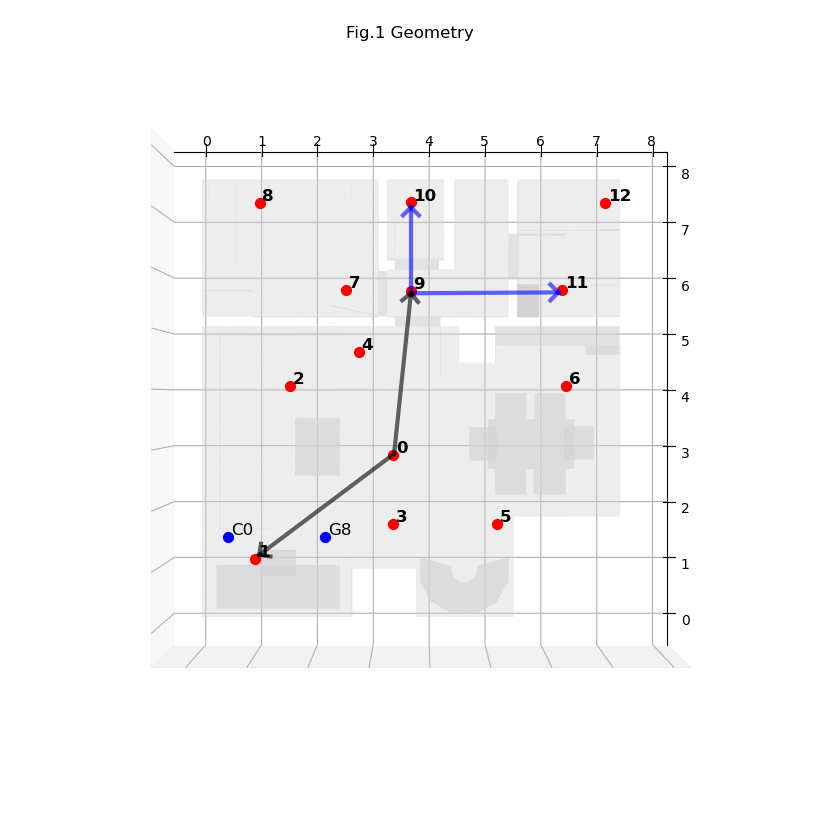

In [3]:
nodes_levels = [
    [['node_0', 'node_1', 'node_9']],
    [['node_9', 'node_10', 'node_11']]
]
#nodes_levels = get_example_topology('ROT') # 'SOT', 'POT' or 'ROT'

if verify_topology(nodes_levels, examples[ex_id]['nodes'].keys()):
    nodes_select = get_unique_node_list(nodes_levels)
    n_async_nodes = len(nodes_select)-1
    plot_positions_and_topology(examples[ex_id], room_model, sig_len_sec, nodes_levels)
else: # force stop
    raise UserWarning('Invalid topology description.')


## 2. Audio- and Metadata

In [4]:
# LOAD AUDIO
audio_reader = AudioReader(data_root=DATA_ROOT, block_length=frame_len, block_shift=frame_len, node_ids=nodes_select, mic_ids='mic_0')
examples = examples.map(audio_reader)

frame_len = np.shape(examples[ex_id]['audio'][nodes_select[0]]['mic_0'])[1]
n_frames_max = min([np.shape(examples[ex_id]['audio'][node_id]['mic_0'])[0] for node_id in nodes_select])
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
if n_frames > n_frames_max:
    n_frames = n_frames_max
    sig_len_prev = sig_len_sec
    sig_len_sec = n_frames*frame_len/fs_Hz
    print('Warning: Audio signals too short for desired simulation length of ', str(sig_len_prev), 's. \nReduced simulation length to ', str(sig_len_sec), 's')
signals = np.stack(tuple(examples[ex_id]['audio'][node]['mic_0'][:n_frames,:] for node in nodes_select), axis=2)

# GET GROUND TRUTH SRO (AND STO)
SRO_true = np.zeros((n_async_nodes))
STO_true = np.zeros((n_async_nodes))
for i in range(1, len(nodes_select)):
    SRO_true[i-1] = examples[ex_id]['nodes'][nodes_select[i]]['sro'] - examples[ex_id]['nodes'][nodes_select[0]]['sro']
    STO_true[i-1] = examples[ex_id]['nodes'][nodes_select[i]]['sto'] - examples[ex_id]['nodes'][nodes_select[0]]['sto'] 

# GET PLACEHOLDER ORACLE ACS
oracle_acs = get_oracle_acs(examples[ex_id], sig_len_sec, len_dxcpphat_est=n_frames, delay=12.8)

### Source activity and scene diary

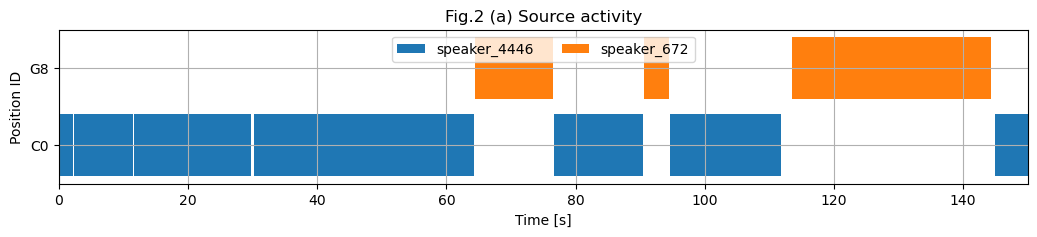

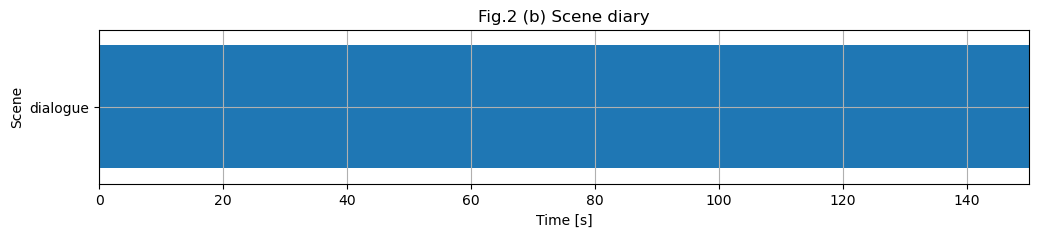

In [5]:
plot_pos_hist(examples[ex_id]['src_diary'], sig_len_sec)
plot_scene_diary(examples[ex_id]['scene_diary'], sig_len_sec)

## 3. Run SRO estimation (by using closed-loop DXCP) and signal synchronization

In [6]:
if SIMULATE_ONLINE:
    print('Running online sequential simulation...')
    signals_synced, SRO_est, dSRO_est = run_simulation_online(nodes_levels, signals, oracle_acs, CONTROL_INIT_SRO_EST)

else:
    print('Running offline multicore simulation...')
    signals_synced, SRO_est, dSRO_est = run_simulation_parallel(nodes_levels, signals, oracle_acs, CONTROL_INIT_SRO_EST)

Running online sequential simulation...


  0%|          | 0/1171 [00:00<?, ?it/s]

## 4. Evaluation Results

In [8]:
# Get synchronous signals (for comparison to synchronized signals)
signals_sync = np.zeros_like(signals)
for i in range(n_async_nodes+1):
    signal_sync = load_audio(DATA_ROOT+'audio/example_0_sync/'+str(nodes_select[i])+'_mic_0.wav')[0:(n_frames*frame_len)]
    signals_sync[:,:,i] = np.reshape(signal_sync, (n_frames, frame_len))
# Calculate evaluation results
rmse_t, nodes_snr, nodes_snr_smoothed, ssnr, ssnr_async = evaluate_simulation_results(nodes_select, fs_Hz, frame_len, SRO_est, SRO_true, signals, signals_synced, signals_sync, ssnr_t_max)

### Reference signal and SNR values at different nodes

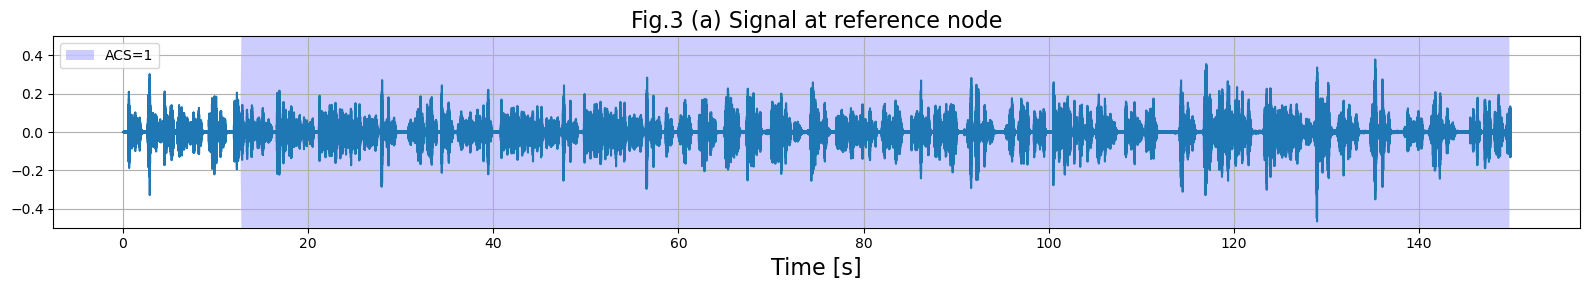

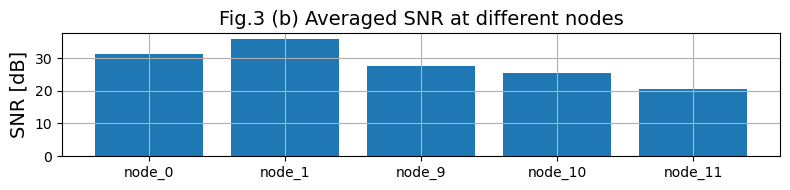

['node_0', 'node_1', 'node_9', 'node_10', 'node_11']
31.24 dB   35.79 dB   27.70 dB   25.31 dB   20.69 dB   

In [9]:
f = plt.figure(); f.set_figwidth(16); f.set_figheight(3)
plt.plot(np.arange(np.size(signals[:,:,0]))/fs_Hz, signals[:,:,0].flatten())
plt.title('Fig.3 (a) Signal at reference node', fontsize=16)
plt.ylim((-0.5, 0.5)); plt.xlabel('Time [s]', fontsize=16)
plt.fill_between(np.arange(len(oracle_acs))*(frame_len/fs_Hz), oracle_acs*0.5, alpha=0.2, color='b', ec=None, label='ACS=1')
plt.fill_between(np.arange(len(oracle_acs))*(frame_len/fs_Hz), -oracle_acs*0.5, alpha=0.2, color='b', ec=None);
plt.legend(loc='upper left')

plt.grid(); 
plt.tight_layout(); 
plt.show()

nodes_snr_smoothed_mean = nodes_snr_smoothed.mean(axis=0)
f = plt.figure(); f.set_figwidth(8); f.set_figheight(2)
plt.bar(range(n_async_nodes+1), nodes_snr_smoothed_mean, tick_label=nodes_select)
plt.title('Fig.3 (b) Averaged SNR at different nodes', fontsize=14)
plt.ylabel('SNR [dB]', fontsize=14)
plt.grid(); plt.tight_layout(); plt.show()
print(nodes_select)
for i in nodes_snr_smoothed_mean:
    print('%5.2f' % i, end=' dB   ')


### Resulting SRO estimation over time

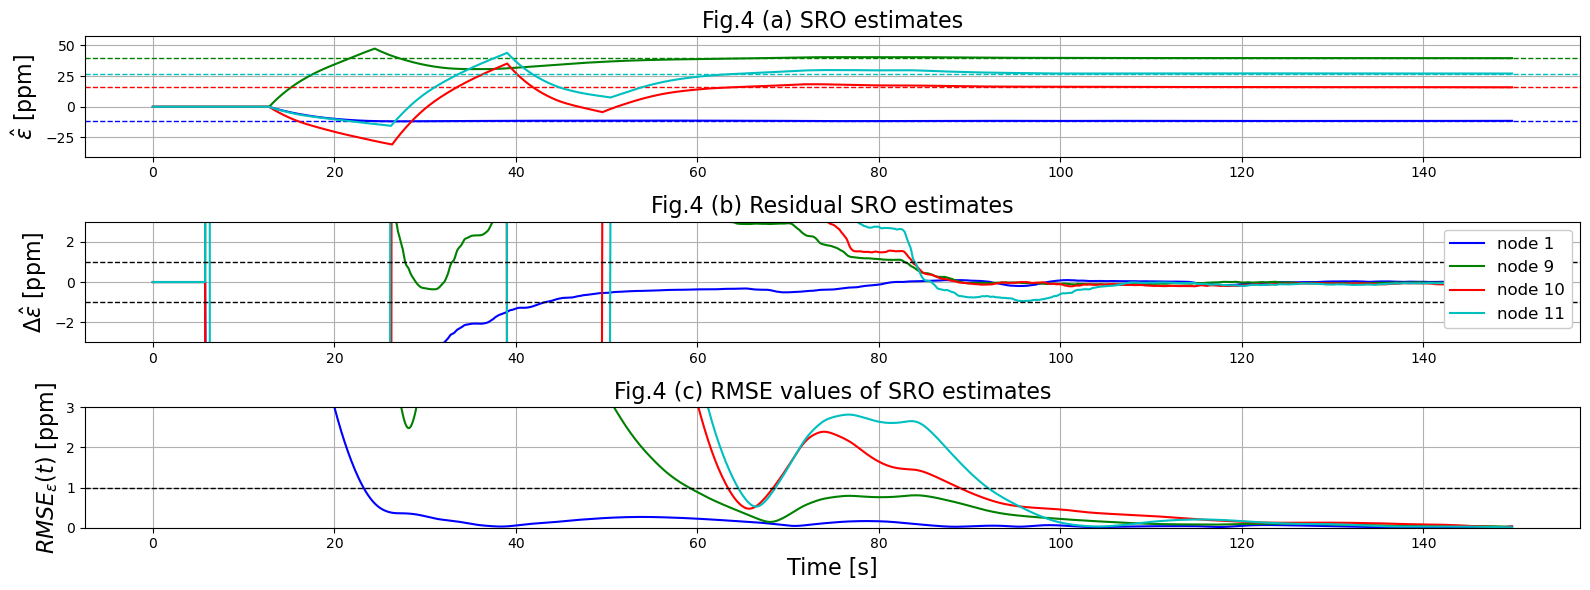

In [10]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, axs = plt.subplots(3, 1, figsize=(16, 6))

for i in range(n_async_nodes):
    axs[0].plot(np.arange(len(SRO_est[:,i]))*(frame_len/fs_Hz), SRO_est[:,i], label=' '.join(nodes_select[i+1].split('_')), color=colors[i%len(colors)])
    axs[0].axhline(y=SRO_true[i], linestyle='--', color=colors[i%len(colors)], lw=1)
axs[0].set_title('Fig.4 (a) SRO estimates', fontsize=16)
axs[0].set_ylabel(r'$\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[0].set_ylim((np.min(SRO_est)-10, np.max(SRO_est)+10))    
axs[0].grid()

for i in range(n_async_nodes):
    axs[1].plot(np.arange(len(dSRO_est[:,i]))*(frame_len/fs_Hz), dSRO_est[:,i], label=' '.join(nodes_select[i+1].split('_')), color=colors[i%len(colors)])
axs[1].legend(loc='upper right', fontsize=12, framealpha=1)
axs[1].set_title('Fig.4 (b) Residual SRO estimates', fontsize=16)
axs[1].axhline(-1, linestyle='--', color='k', lw=1)
axs[1].axhline(1, linestyle='--', color='k', lw=1)
axs[1].set_ylabel(r'$\Delta\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[1].set_ylim((-3, 3)); axs[1].grid()

for i in range(n_async_nodes):
    axs[2].plot(np.arange(len(SRO_est[:,i]))*(frame_len/fs_Hz), rmse_t[:,i], label=' '.join(nodes_select[i+1].split('_')), color=colors[i%len(colors)])
axs[2].set_title('Fig.4 (c) RMSE values of SRO estimates', fontsize=16)
axs[2].set_ylabel(r'$RMSE_\varepsilon(t)$ [ppm]', fontsize=16)
axs[2].axhline(1, linestyle='--', color='k', lw=1)
axs[2].set_ylim((0, 3)); axs[2].grid()

axs[-1].set_xlabel('Time [s]', fontsize=16)
plt.tight_layout(); 
plt.show()

### Synchronization performance

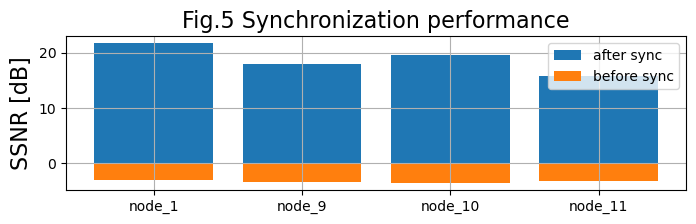

['node_1', 'node_9', 'node_10', 'node_11']
-3.10 dB   -3.29 dB   -3.58 dB   -3.28 dB    
21.69 dB   17.99 dB   19.47 dB   15.73 dB   

In [11]:
f = plt.figure(); f.set_figwidth(8); f.set_figheight(2)
plt.bar(range(n_async_nodes), ssnr, tick_label=nodes_select[1:], label='after sync')
plt.bar(range(n_async_nodes), ssnr_async, tick_label=nodes_select[1:], label='before sync')
plt.title('Fig.5 Synchronization performance', fontsize=16)
plt.ylabel('SSNR [dB]', fontsize=16)
plt.legend()
plt.grid(); plt.show()

print(nodes_select[1:])
for i in ssnr_async:
    print('%5.2f' % i, end=' dB   ')
print(' ')
for i in ssnr:
    print('%5.2f' % i, end=' dB   ')